# Preprocess HBEC IFN data

For now, isolate the Type I interferons

In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = '/data_volume/memento/hbec/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'


In [3]:
%matplotlib inline

### Read the data

In [ ]:
adata = sc.read(data_path + 'HBEC_condition_assigned_deep.h5ad')
adata = adata[adata.obs.condition != 'unassigned'].copy()

In [ ]:
adata.obs['donor'] = adata.obs['condition'].apply(lambda x: x.split('_')[0])
adata.obs['stim'] = adata.obs['condition'].apply(lambda x: x.split('_')[1])
adata.obs['time'] = adata.obs['condition'].apply(lambda x: x.split('_')[2] if 'control' not in x else 0)

In [ ]:
adata.shape

In [ ]:
# adata = adata[(adata.obs['stim'].isin(['control', 'alpha', 'beta']))]

### Slice out mRNA from ADT

In [ ]:
adt_adata = adata[:, adata.var.query('feature_types == "Antibody Capture" & ~gene_ids.str.contains("hash").values').index].copy()
rna_adata = adata[:, adata.var.query('feature_types != "Antibody Capture"').index].copy()

In [9]:
rna_adata.shape

(80654, 36601)

In [10]:
rna_adata.obs.stim.value_counts()/rna_adata.shape[0]

beta       0.249882
alpha      0.242964
gamma      0.241501
lambda     0.227986
control    0.037667
Name: stim, dtype: float64

### Process RNA data

In [46]:
rna_adata.obs.head(5)

NUM.SNPS BEST.GUESS DROPLET.TYPE batch HTO_classification  \
AAACCCAAGGAAGTAG-1      1700     donor0          SNG     0            hash-10   
AAACCCAAGGGACTGT-1       839     donor0          SNG     0             hash-3   
AAACCCACAATCTGCA-1      1130     donor1          SNG     0             hash-1   
AAACCCACACGTTCGG-1       989     donor1          SNG     0             hash-1   
AAACCCACAGAACTAA-1       997     donor1          SNG     0             hash-8   

                         condition  donor    stim time  n_genes  \
AAACCCAAGGAAGTAG-1  d2513_lambda_9  d2513  lambda    9     4297   
AAACCCAAGGGACTGT-1  d2513_alpha_24  d2513   alpha   24     2171   
AAACCCACAATCTGCA-1   d2614_alpha_3  d2614   alpha    3     3016   
AAACCCACACGTTCGG-1   d2614_alpha_3  d2614   alpha    3     2748   
AAACCCACAGAACTAA-1  d2614_gamma_48  d2614   gamma   48     2885   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGGAAGTAG-1               4297       12191.0           1394.0   
AAACCCAAGGGACTGT-1               2171        7270.0            386.0   
AAACCCACAATCTGCA-1               3016        9544.0            516.0   
AAACCCACACGTTCGG-1               2748        8248.0            583.0   
AAACCCACAGAACTAA-1               2885        7765.0            729.0   

                    pct_counts_mt leiden  
AAACCCAAGGAAGTAG-1      11.434665      3  
AAACCCAAGGGACTGT-1       5.309491      5  
AAACCCACAATCTGCA-1       5.406538      0  
AAACCCACACGTTCGG-1       7.068380     19  
AAACCCACAGAACTAA-1       9.388281     14

In [16]:
sc.pp.filter_cells(rna_adata, min_genes=50)
# sc.pp.filter_genes(rna_adata, min_cells=500)

In [17]:
rna_adata.var['mt'] = rna_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [18]:
# rna_adata = rna_adata[rna_adata.obs.n_genes_by_counts < 2500, :]
rna_adata = rna_adata[rna_adata.obs.pct_counts_mt < 20, :]

In [19]:
rna_adata.shape

(69958, 36601)

In [20]:
rna_adata.obs.stim.value_counts()/rna_adata.shape[0]

beta       0.261271
alpha      0.256797
gamma      0.234626
lambda     0.213571
control    0.033735
Name: stim, dtype: float64

In [21]:
rna_adata_counts = rna_adata.copy()

In [22]:
sc.pp.normalize_total(rna_adata, target_sum=1e4)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
sc.pp.log1p(rna_adata)

In [24]:
rna_adata.raw = rna_adata

In [25]:
sc.pp.highly_variable_genes(rna_adata, min_mean=0.01, max_mean=3, min_disp=0.5, batch_key='donor')

... storing 'donor' as categorical
... storing 'stim' as categorical
... storing 'time' as categorical


In [26]:
rna_adata = rna_adata[:, rna_adata.var.highly_variable & ~rna_adata.var.mt]

In [27]:
rna_adata.raw.shape

(69958, 36601)

In [28]:
sc.pp.regress_out(rna_adata, ['total_counts', 'pct_counts_mt'])

In [29]:
# sc.pp.combat(rna_adata, key='donor')

In [30]:
sc.pp.scale(rna_adata, max_value=10)

In [31]:
sc.tl.pca(rna_adata, svd_solver='arpack')

In [32]:
sc.pp.neighbors(rna_adata, n_neighbors=30, n_pcs=40)


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/envs/single_cell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../

In [33]:
sc.tl.umap(rna_adata)

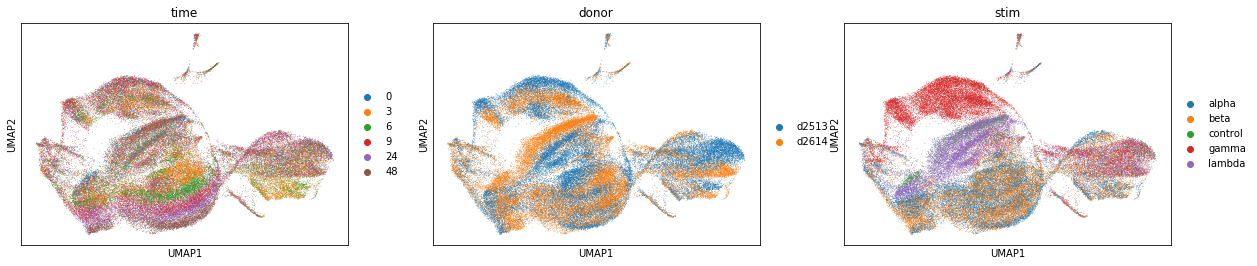

In [34]:
sc.pl.umap(rna_adata, color=['time', 'donor', 'stim'])

### Clustering

In [35]:
sc.tl.leiden(rna_adata, resolution=1.5)

In [36]:
rna_adata.obs.head(5)

NUM.SNPS BEST.GUESS DROPLET.TYPE batch HTO_classification  \
AAACCCAAGGAAGTAG-1      1700     donor0          SNG     0            hash-10   
AAACCCAAGGGACTGT-1       839     donor0          SNG     0             hash-3   
AAACCCACAATCTGCA-1      1130     donor1          SNG     0             hash-1   
AAACCCACACGTTCGG-1       989     donor1          SNG     0             hash-1   
AAACCCACAGAACTAA-1       997     donor1          SNG     0             hash-8   

                         condition  donor    stim time  n_genes  \
AAACCCAAGGAAGTAG-1  d2513_lambda_9  d2513  lambda    9     4297   
AAACCCAAGGGACTGT-1  d2513_alpha_24  d2513   alpha   24     2171   
AAACCCACAATCTGCA-1   d2614_alpha_3  d2614   alpha    3     3016   
AAACCCACACGTTCGG-1   d2614_alpha_3  d2614   alpha    3     2748   
AAACCCACAGAACTAA-1  d2614_gamma_48  d2614   gamma   48     2885   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGGAAGTAG-1               4297       12191.0           1394.0   
AAACCCAAGGGACTGT-1               2171        7270.0            386.0   
AAACCCACAATCTGCA-1               3016        9544.0            516.0   
AAACCCACACGTTCGG-1               2748        8248.0            583.0   
AAACCCACAGAACTAA-1               2885        7765.0            729.0   

                    pct_counts_mt leiden  
AAACCCAAGGAAGTAG-1      11.434665      3  
AAACCCAAGGGACTGT-1       5.309491      5  
AAACCCACAATCTGCA-1       5.406538      0  
AAACCCACACGTTCGG-1       7.068380     19  
AAACCCACAGAACTAA-1       9.388281     14

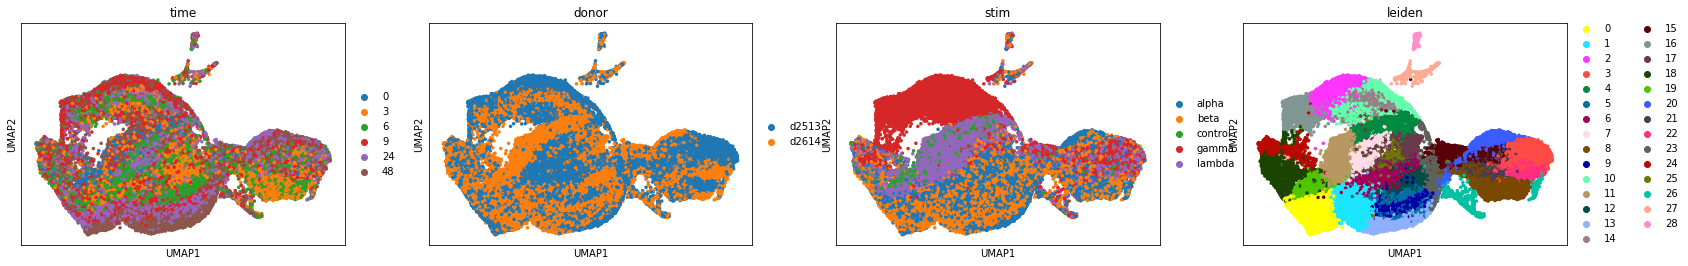

In [37]:
sc.pl.umap(rna_adata, color=['time', 'donor', 'stim', 'leiden'], s=50)

### Identify cell types using marker genes

In [38]:
import pandas as pd

In [39]:
marker_genes = ['KRT5', 'DAPL1', 'TP63', 'KRT4', 'KRT13', 'SCGB1A1','KRT15', 'LYPD2','FOXJ1', 'CCDC113','CCDC153',
                'MLF1', 'LZTFL1','CHGA', 'ASCL1', 'POU2F3', 'AVIL', 'GNAT3','FOXI1', 'CFTR', 'ASCL3', 'MUC5AC', 'MUC5B', 'GP2','SPDEF']


In [40]:
marker_matrix = rna_adata.raw[:, marker_genes].X

In [41]:
marker_df = pd.DataFrame(marker_matrix.toarray(), columns=marker_genes)
marker_df['cluster'] = rna_adata.obs.leiden.values
marker_df = marker_df.groupby('cluster')[marker_genes].mean()
marker_df[marker_genes] = marker_df[marker_genes]/marker_df[marker_genes].max(axis=0)

In [42]:
adt_marker_df = pd.DataFrame(adt_adata[rna_adata.obs.index, -11:].X.toarray(), columns=adt_adata.var.tail(11).index)
adt_marker_df['cluster'] = rna_adata.obs.leiden.values
adt_marker_df = adt_marker_df.groupby('cluster').mean()
# adt_marker_df = adt_marker_df/adt_marker_df.max(axis=0)

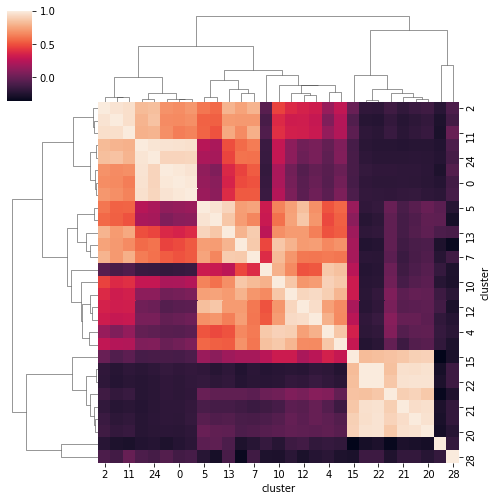

In [45]:
cg = sns.clustermap(marker_df.T.corr(), figsize=(7,7))

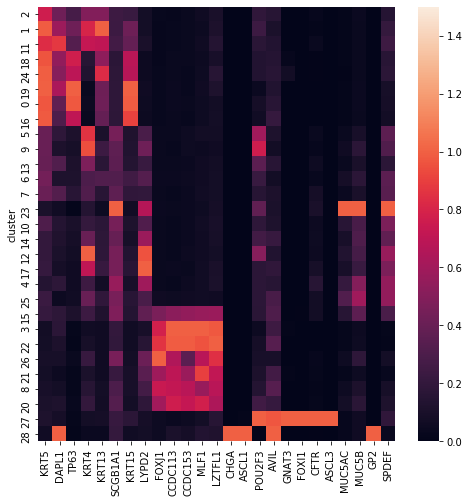

In [44]:
order = cg.dendrogram_row.reordered_ind
plt.figure(figsize=(8,8))
sns.heatmap(marker_df.iloc[order, :], vmax=1.5)

In [58]:
cell_type_converter = \
    ['basal' for i in range(8)] + \
    ['basal/club' for i in range(5)] + \
    ['goblet'] + \
    ['basal/club' for i in range(6)] + \
    ['ciliated' for i in range(7)] + \
    ['ionocyte/tuft'] + ['neuroendo']
cell_type_converter = dict(zip(order, cell_type_converter))

In [59]:
rna_adata.obs['cell_type'] = rna_adata.obs['leiden'].apply(lambda x: cell_type_converter[int(x)])

... storing 'cell_type' as categorical


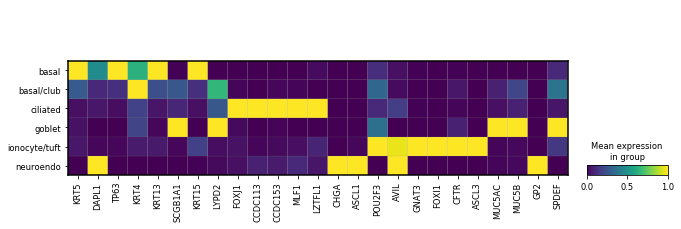

In [60]:
sc.pl.matrixplot(rna_adata, marker_genes, groupby='cell_type', standard_scale='var')

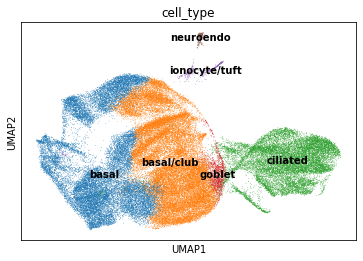

In [61]:
sc.pl.umap(rna_adata, color='cell_type', legend_loc='on data')

### Save the objects

In [62]:
rna_adata.write(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [63]:
rna_adata_counts.obs = rna_adata.obs
rna_adata_counts.write(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

### Make expression histograms

In [19]:
rna_adata_counts = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [20]:
sc.pp.normalize_total(rna_adata_counts, target_sum=1e4)

In [21]:
sc.pp.log1p(rna_adata_counts)

In [22]:
rna_adata_counts.obs['GBP1'] = rna_adata_counts[:, 'GBP1'].X.toarray()
rna_adata_counts.obs['STAT1'] = rna_adata_counts[:, 'STAT1'].X.toarray()

In [23]:
dat = rna_adata_counts.obs.query('(stim == "gamma" | stim == "control") & cell_type == "ciliated"')

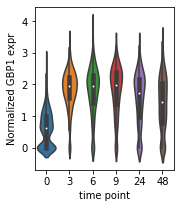

In [30]:
plt.figure(figsize=(2.5,3))
sns.violinplot(x='time', y='GBP1', data=dat)
plt.ylabel('Normalized GBP1 expr'); plt.xlabel('time point')
plt.savefig(fig_path + 'violin_GBP1.pdf', bbox_inches='tight')

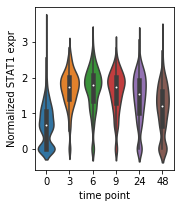

In [31]:
plt.figure(figsize=(2.5,3))
sns.violinplot(x='time', y='STAT1', data=dat);
plt.ylabel('Normalized STAT1 expr'); plt.xlabel('time point')
plt.savefig(fig_path + 'violin_STAT1.pdf', bbox_inches='tight')

### Make plots for figure

In [4]:
sc.set_figure_params(dpi=300)
fig_path = ''
sc.settings.figdir = fig_path

In [5]:
rna_adata = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [8]:
adata.uns['umap']['params']

{'params': {'a': 0.583030019901822, 'b': 1.3341669931033755}}

In [8]:
rna_adata.shape

(69958, 3064)

In [10]:
rna_adata.obs['time_step'] = rna_adata.obs['time'].astype(float)

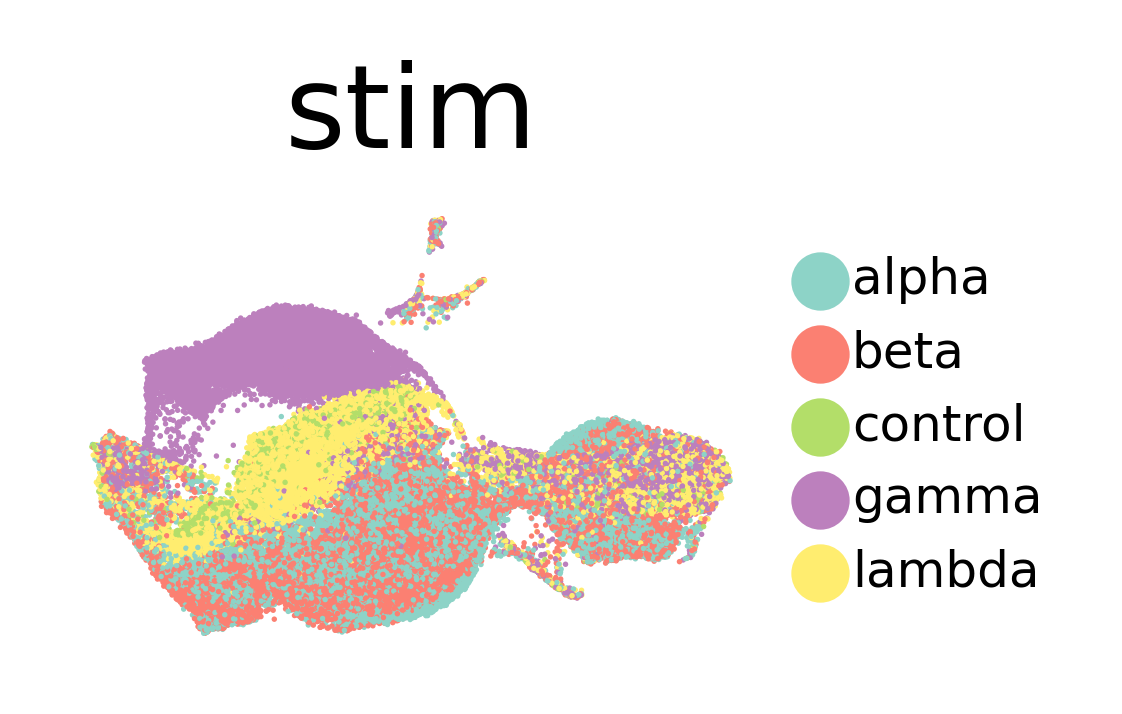

In [31]:
fig, ax = plt.subplots(figsize=(1.5,1))

sc.pl.umap(rna_adata, color='stim', ax=ax, save='_stim_pastel.png', legend_fontsize=6, palette='Set3', frameon=False);

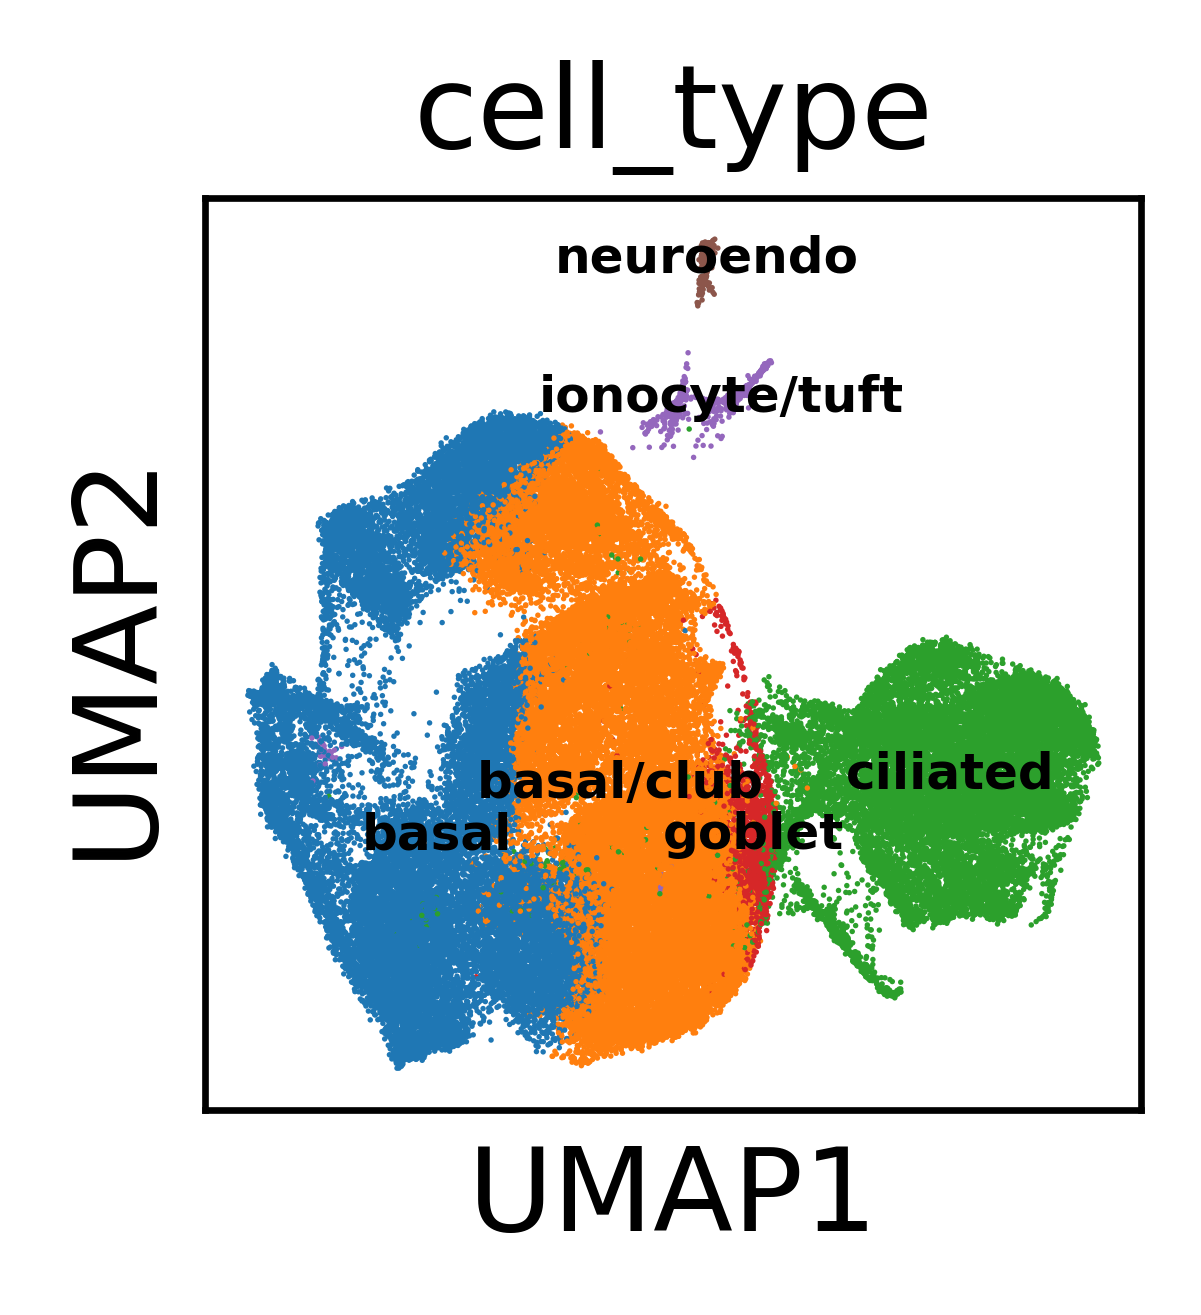

In [12]:
fig, ax = plt.subplots(figsize=(2,2))
sc.pl.umap(rna_adata, color='cell_type', legend_loc='on data', ax=ax, save='_ct.png', legend_fontsize=6);

In [ ]:
fig, ax = plt.subplots(figsize=(2,2))
sc.pl.umap(rna_adata, color='stim', ax=ax, save='_stim.png')

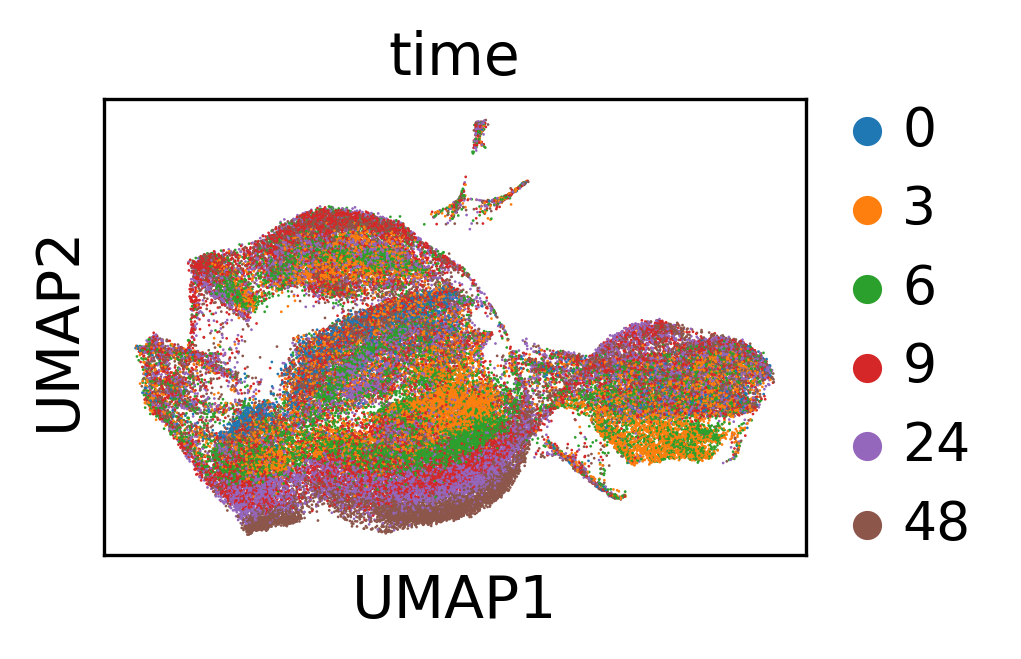

Text(0.5, 1.0, '')

In [17]:
fig, ax = plt.subplots(figsize=(3,2))
sc.pl.umap(rna_adata, color='time', ax=ax, save='_time.png')
ax.set_title(None)

### Cluster the ciliated cells for downstream analysis separately

In [67]:
ciliated_adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')
ciliated_adata = ciliated_adata[ciliated_adata.obs['cell_type'] == 'ciliated'].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [68]:
sc.pp.normalize_total(ciliated_adata, target_sum=1e4)
sc.pp.log1p(ciliated_adata)
ciliated_adata.raw = ciliated_adata
sc.pp.highly_variable_genes(ciliated_adata, min_mean=0.01, max_mean=3, min_disp=0.5, batch_key='donor')
ciliated_adata = ciliated_adata[:, ciliated_adata.var.highly_variable & ~ciliated_adata.var.mt]



In [69]:
ciliated_adata.obs['is_donor'] = (ciliated_adata.obs['donor'] == 'd2513').astype(int)

Trying to set attribute `.obs` of view, copying.


In [70]:
sc.pp.regress_out(ciliated_adata, ['total_counts', 'pct_counts_mt',])
sc.pp.scale(ciliated_adata, max_value=10)
sc.tl.pca(ciliated_adata, svd_solver='arpack')

In [96]:
sc.pp.neighbors(ciliated_adata, n_neighbors=50, n_pcs=10)
sc.tl.umap(ciliated_adata)

In [97]:
ciliated_adata.obs['is_control'] = (ciliated_adata.obs['time'] == '0').astype(int)

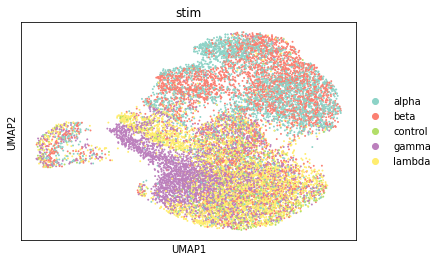

In [98]:
sc.pl.umap(ciliated_adata, color='stim', s=15, palette='Set3')

In [100]:
ciliated_adata.obs['tp_idx'] = ciliated_adata.obs['time'].map(lambda x: {'0':0, '3':1, '6':2, '9':3, '24':4, '48':5}[x]).astype(float)

In [149]:
pal = sns.mpl_palette("Greys", 12)
pal = pal[1:3] + pal[-4:]

In [150]:
pal

[(0.9210149942329873, 0.9210149942329873, 0.9210149942329873),
 (0.8644213763936948, 0.8644213763936948, 0.8644213763936948),
 (0.37942329873125724, 0.37942329873125724, 0.37942329873125724),
 (0.2952710495963093, 0.2952710495963093, 0.2952710495963093),
 (0.1845444059976932, 0.1845444059976932, 0.1845444059976932),
 (0.08648981161091888, 0.08648981161091888, 0.08648981161091888)]

In [151]:
sns.mpl_palette("Greys", 12)

[(0.9649365628604383, 0.9649365628604383, 0.9649365628604383),
 (0.9210149942329873, 0.9210149942329873, 0.9210149942329873),
 (0.8644213763936948, 0.8644213763936948, 0.8644213763936948),
 (0.8018915801614763, 0.8018915801614763, 0.8018915801614763),
 (0.7297808535178778, 0.7297808535178778, 0.7297808535178778),
 (0.6338177623990773, 0.6338177623990773, 0.6338177623990773),
 (0.5473279507881584, 0.5473279507881584, 0.5473279507881584),
 (0.4612072279892349, 0.4612072279892349, 0.4612072279892349),
 (0.37942329873125724, 0.37942329873125724, 0.37942329873125724),
 (0.2952710495963093, 0.2952710495963093, 0.2952710495963093),
 (0.1845444059976932, 0.1845444059976932, 0.1845444059976932),
 (0.08648981161091888, 0.08648981161091888, 0.08648981161091888)]

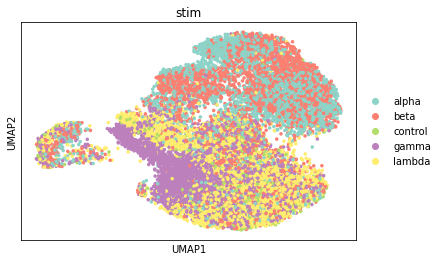

In [99]:
sc.pl.umap(ciliated_adata, color='stim', s=50)

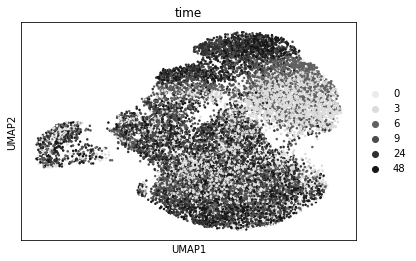

In [152]:
sc.pl.umap(ciliated_adata, color='time', s=25, palette=pal)

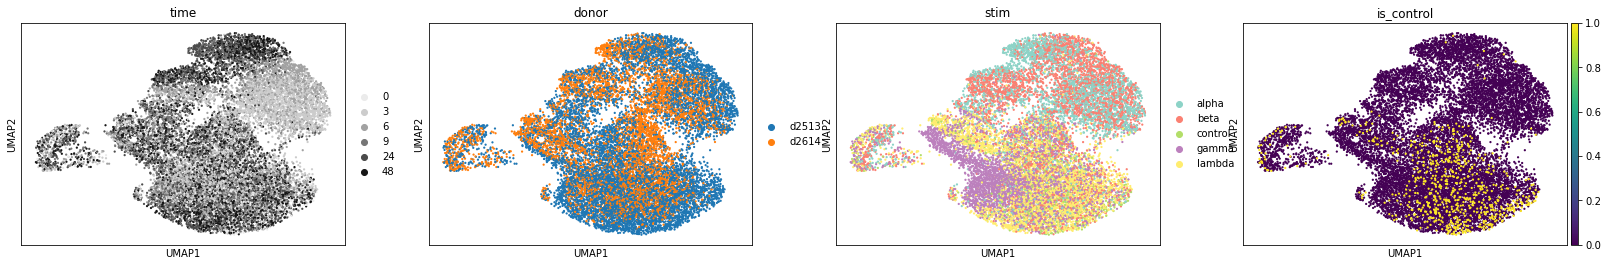

In [103]:
sc.pl.umap(ciliated_adata, color=['time', 'donor', 'stim', 'is_control'], s=20)

In [129]:
sc.tl.leiden(ciliated_adata, resolution=.1)

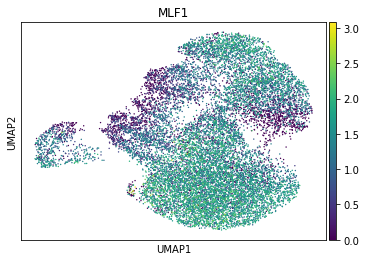

In [134]:
sc.pl.umap(ciliated_adata, color='MLF1')

In [132]:
sc.tl.rank_genes_groups(ciliated_adata, 'leiden')

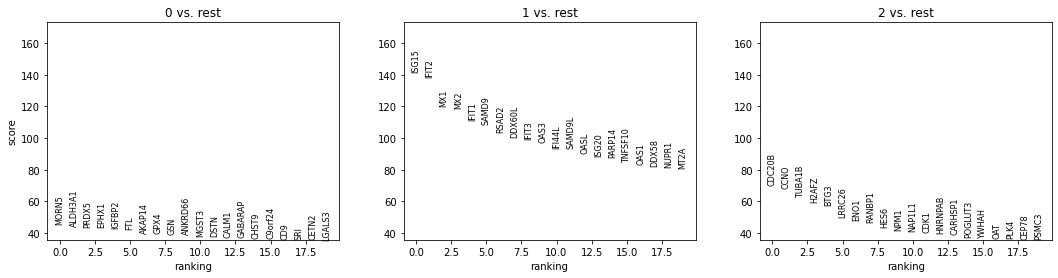

In [133]:
sc.pl.rank_genes_groups(ciliated_adata)

In [27]:
rna_adata.raw.shape

(69958, 36601)

In [29]:
# sc.pp.combat(rna_adata, key='donor')

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/envs/single_cell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../

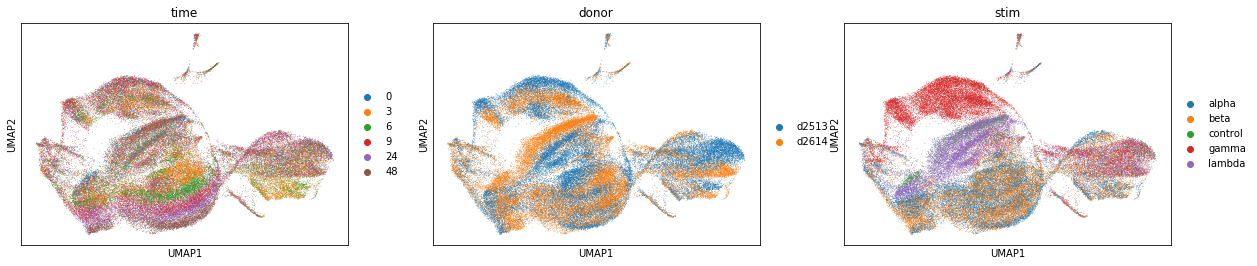

In [34]:
sc.pl.umap(rna_adata, color=['time', 'donor', 'stim'])